# The Harvard Automated Processing Pipeline in Low Electrode Electroencephalography (HAPPILEE)

## Data input
* First, the user selects which file type that will be loaded (.csv or .edf).  
[input: ```1```]
* Then, the user inputs the path to the file, including the file name.  
[input: ```ExG_data/offline_exp_ExG-30s.csv```]
* The number of channels is detected from the loaded data.  
* The user inputs the channel names that were recorded (e.g. Fp1, Fp2, O1, etc.).  
[input: ```POz```, ```Oz```, ```O1```, ```O2```]
* The user inputs the line frequency.  
[input: ```50```]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_input

# Loading ExG data
file_format = data_input.in_file_format()
ExGdata = data_input.in_ExGdata(file_format)
n_chan = data_input.get_n_chan(ExGdata)
ch_names = data_input.in_ch_names(n_chan)
s_rate = data_input.get_s_rate(ExGdata)
ln_freq = data_input.in_ln_freq()
A = data_input.ExG_data(file_format, ExGdata, n_chan, ch_names, s_rate, ln_freq)



In [2]:
print("File format (1: .csv, 2: .edf):", A.file_format)
print("Number of channels:", A.n_chan)
print("Timestamps (s):", A.ExGdata[0, :])
print("Channel names: ", A.ch_names)
print("Sampling rate: ", A.s_rate)
print("Line frequency: ", A.ln_freq)
print("ExGdata shape:", A.ExGdata.shape)


File format (1: .csv, 2: .edf): 1
Number of channels: 8
Timestamps (s): [0.000e+00 4.000e-03 8.000e-03 ... 9.992e+00 9.996e+00 1.000e+01]
Channel names:  ['1', '2', '3', '4', '5', '6', '7', '8']
Sampling rate:  250
Line frequency:  50
ExGdata shape: (9, 2501)


(9, 2501)


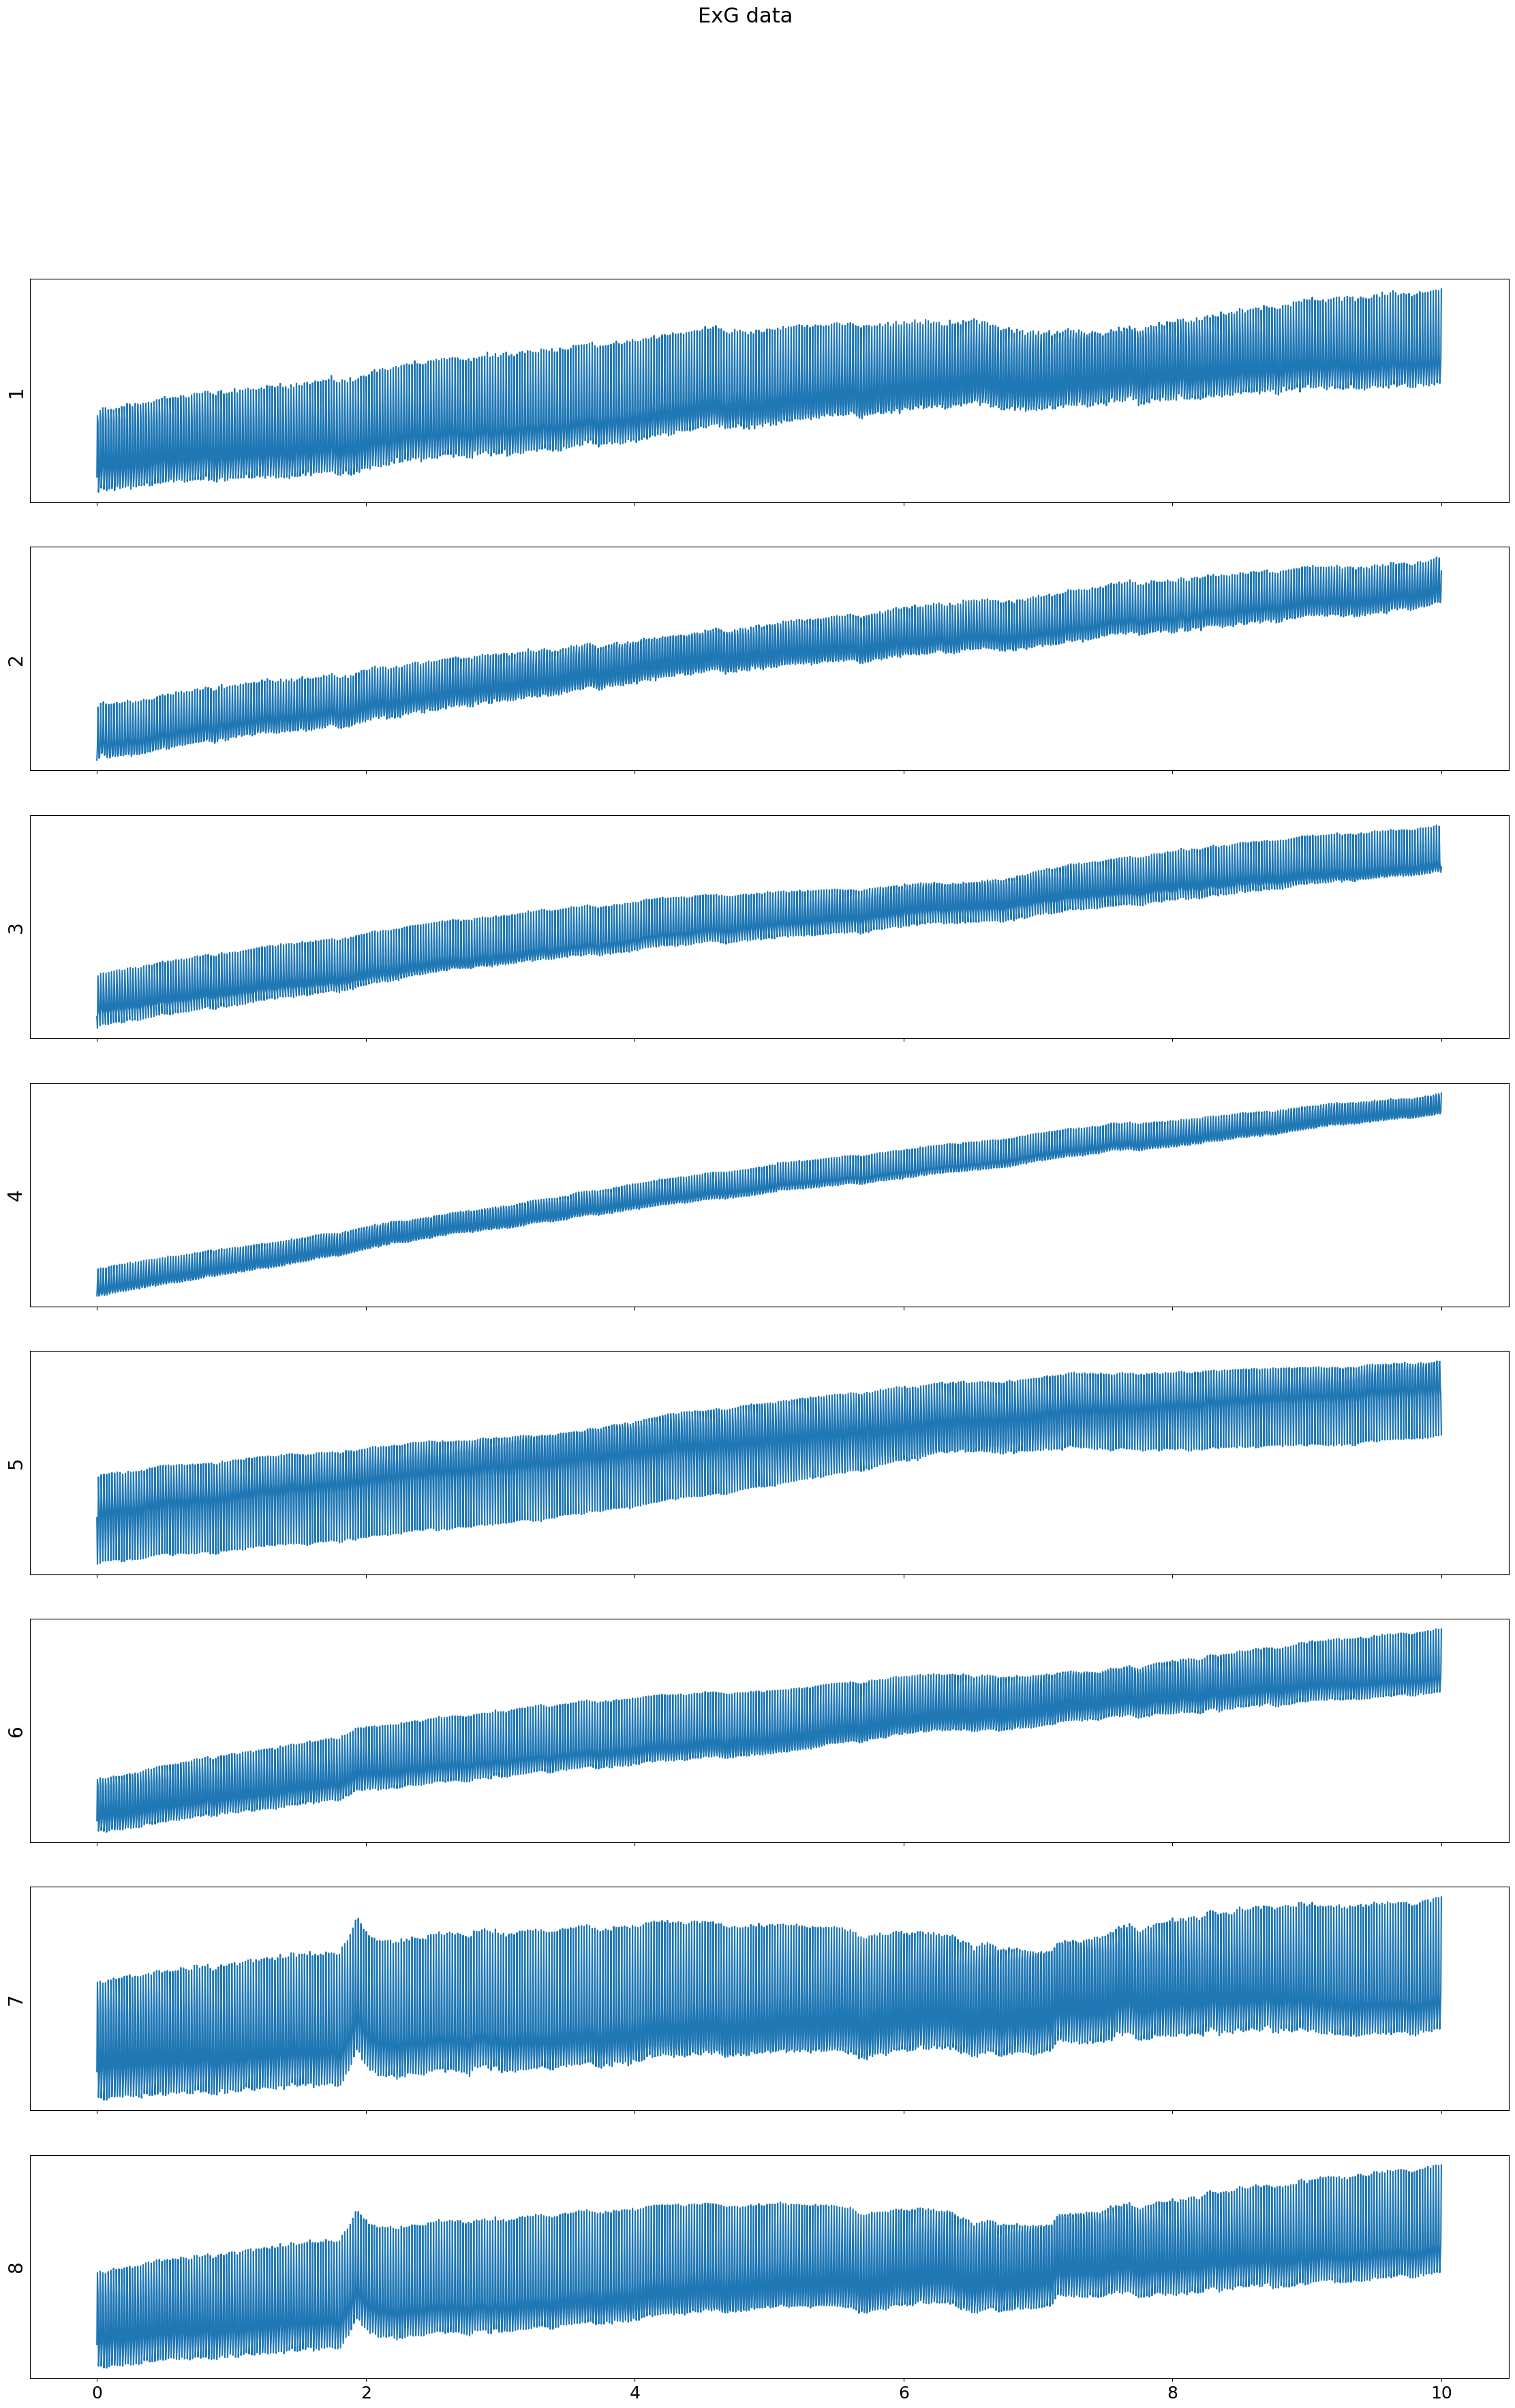

In [4]:
print(A.ExGdata.shape)
A.plot_ExGdata()


## 1. Channel Selection
* The user selects which channels to process.  
    * To process all channels, input ```all```
    * To process select channels, input ```coi```
* If ```coi``` is selected, the user inputs the selected channel names.
    * Example: ```O1```, ```O2```, ```done```

In [5]:
import ch_selection

# Select channels from the loaded data that will be processed
ExG_sel = ch_selection.select(A)

In [6]:
print("File format (1: .csv, 2: .edf):", ExG_sel.file_format)
print("Number of channels:", ExG_sel.n_chan)
print("Channel names: ", ExG_sel.ch_names)
print("Sampling rate: ", ExG_sel.s_rate)
print("Line frequency: ", ExG_sel.ln_freq)
print("ExGdata shape:", ExG_sel.ExGdata.shape)

File format (1: .csv, 2: .edf): 1
Number of channels: 8
Channel names:  ['1', '2', '3', '4', '5', '6', '7', '8']
Sampling rate:  250
Line frequency:  50
ExGdata shape: (9, 2501)


In [ ]:
# Plot the selected ExG data
ExG_sel.plot_ExGdata()

## 2. Line Noise Removal

Removed notch frequencies (Hz):
     50.00 :   32 windows
    100.00 :   32 windows
(9, 2501)


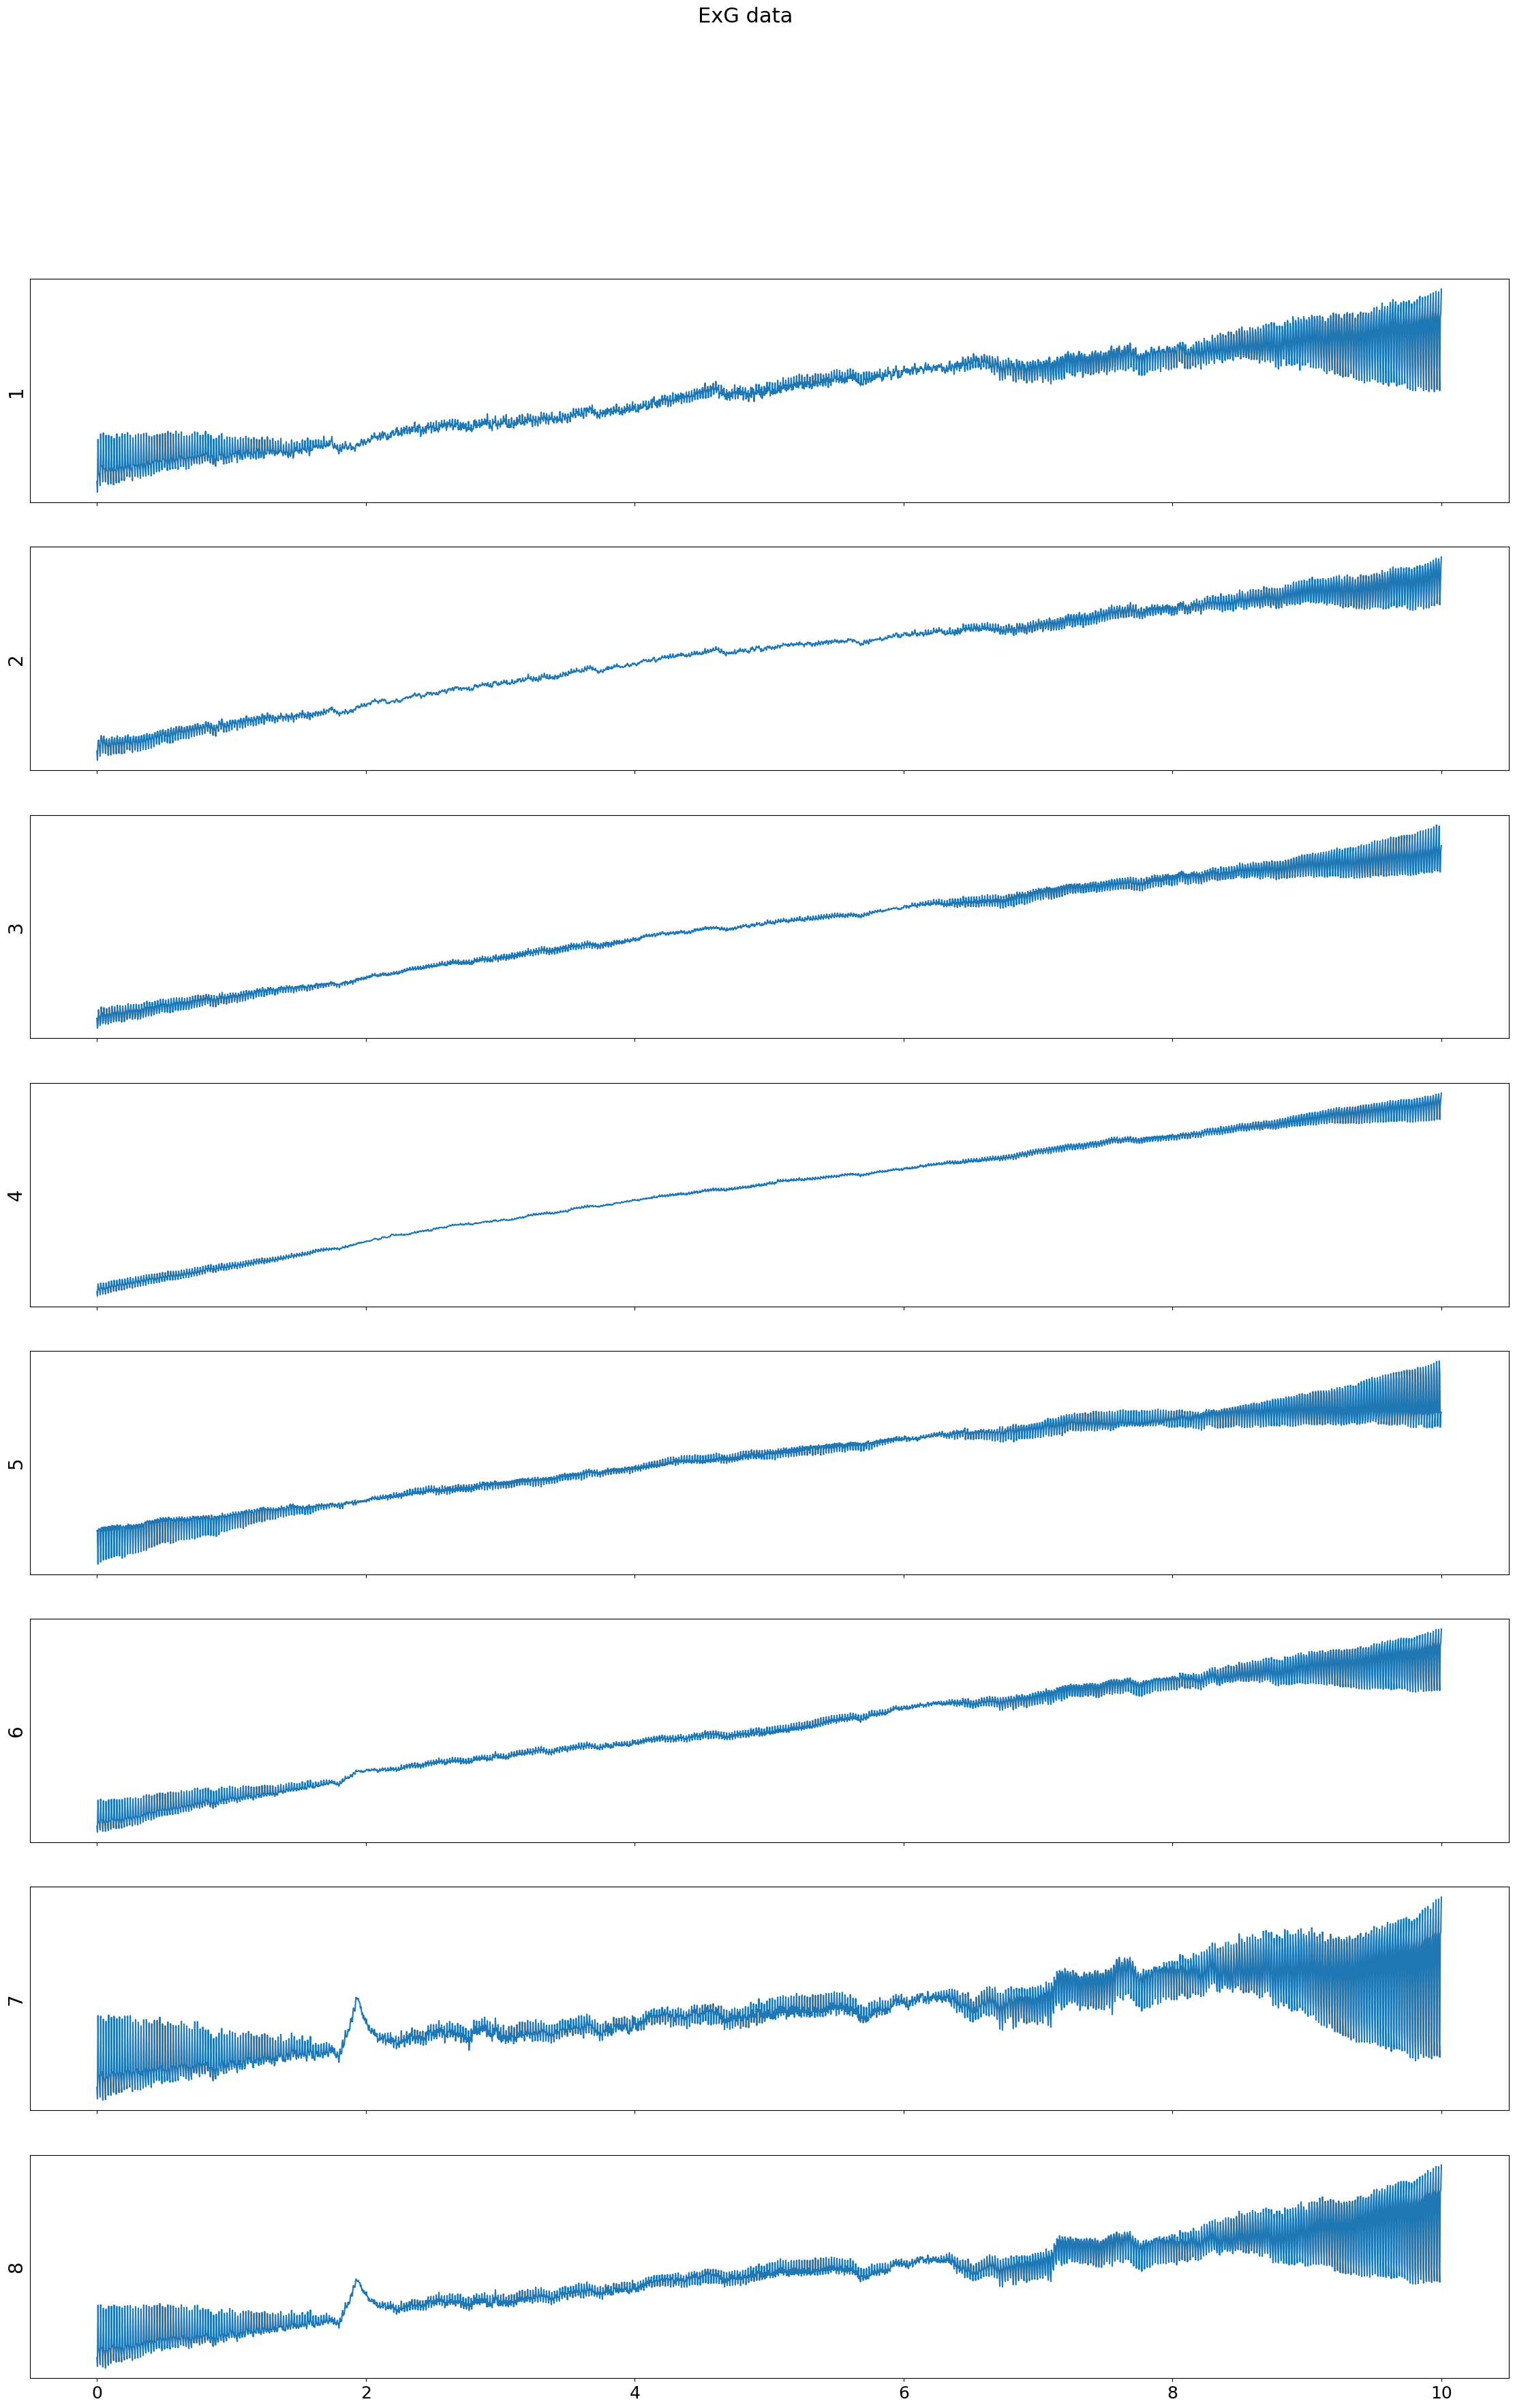

In [7]:
import ln_removal

ExG_ln_rm = ln_removal.clean_ln(ExG_sel)


print(ExG_ln_rm.ExGdata.shape)

ExG_ln_rm.plot_ExGdata()
ExG_ln_rm.save_to_csv('out_ExG_ln_rm.csv')

## 3. Filtering
* Applies a low-pass filter at 30 Hz prior to artifact rejection.

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 111 samples (0.444 s)



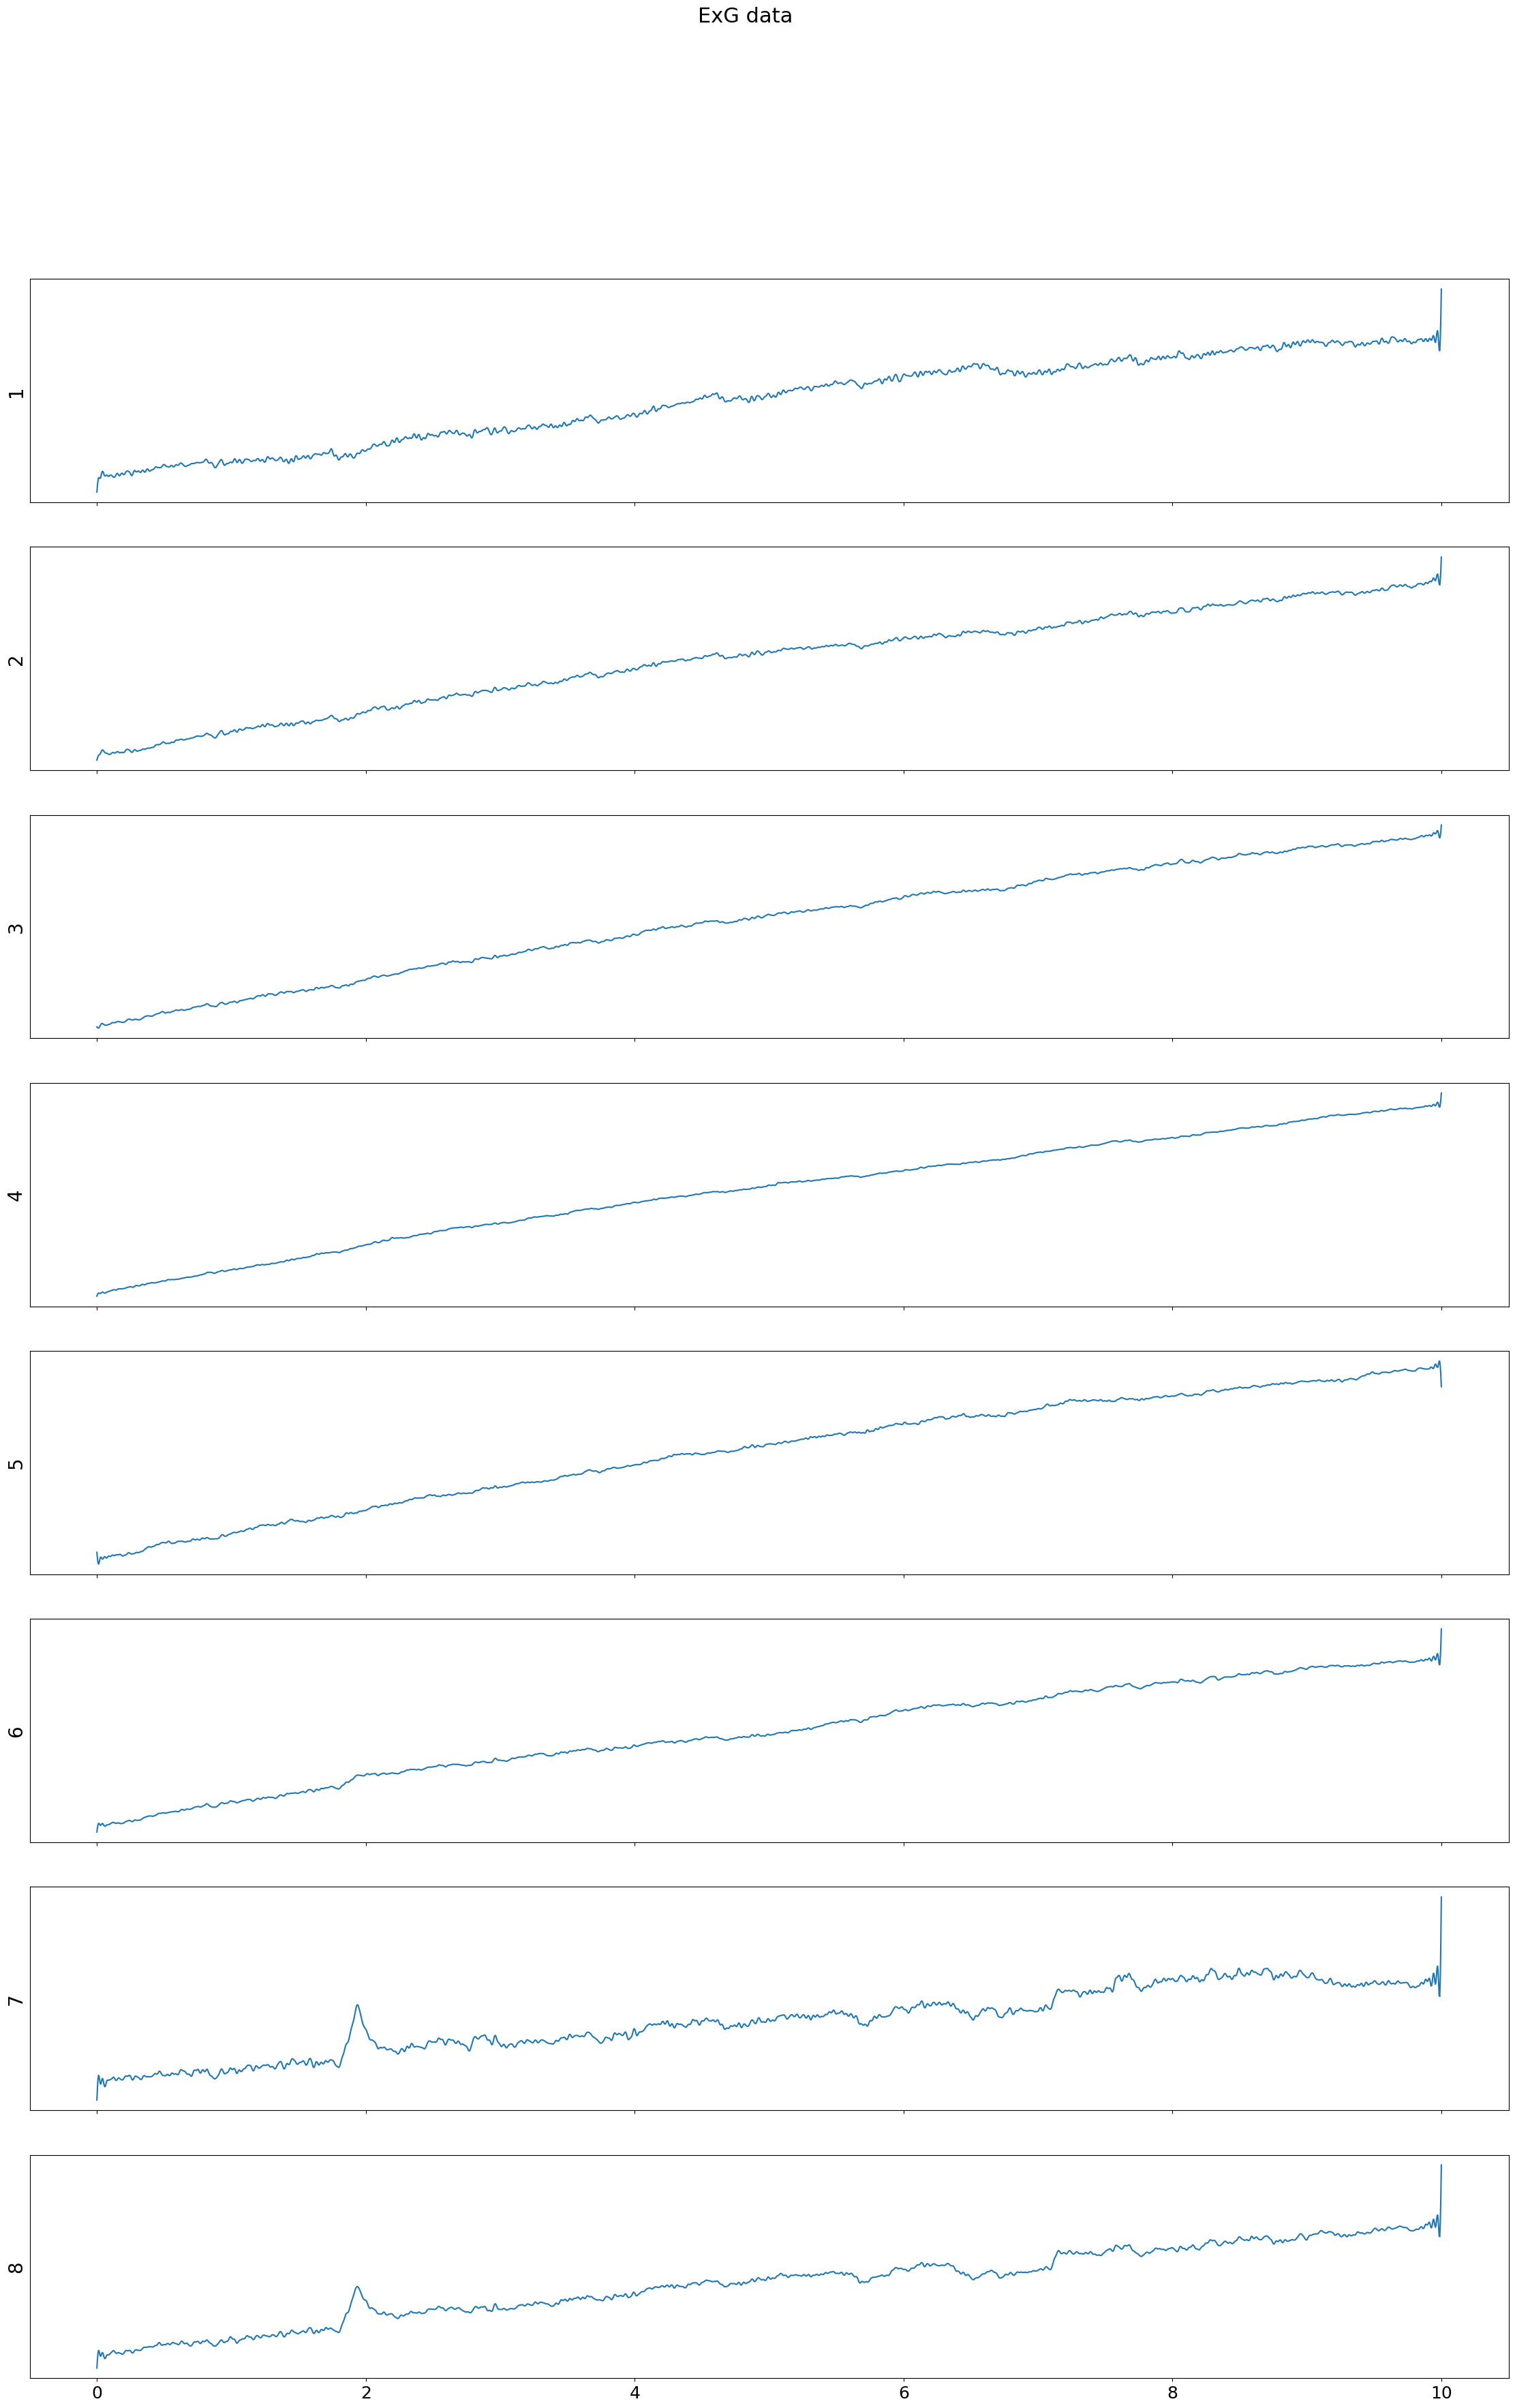

In [8]:
import filtering

ExG_lpf = filtering.lp_filt(ExG_ln_rm, 30)
ExG_lpf.plot_ExGdata()
ExG_lpf.save_to_csv('out_ExG_lpf.csv')


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



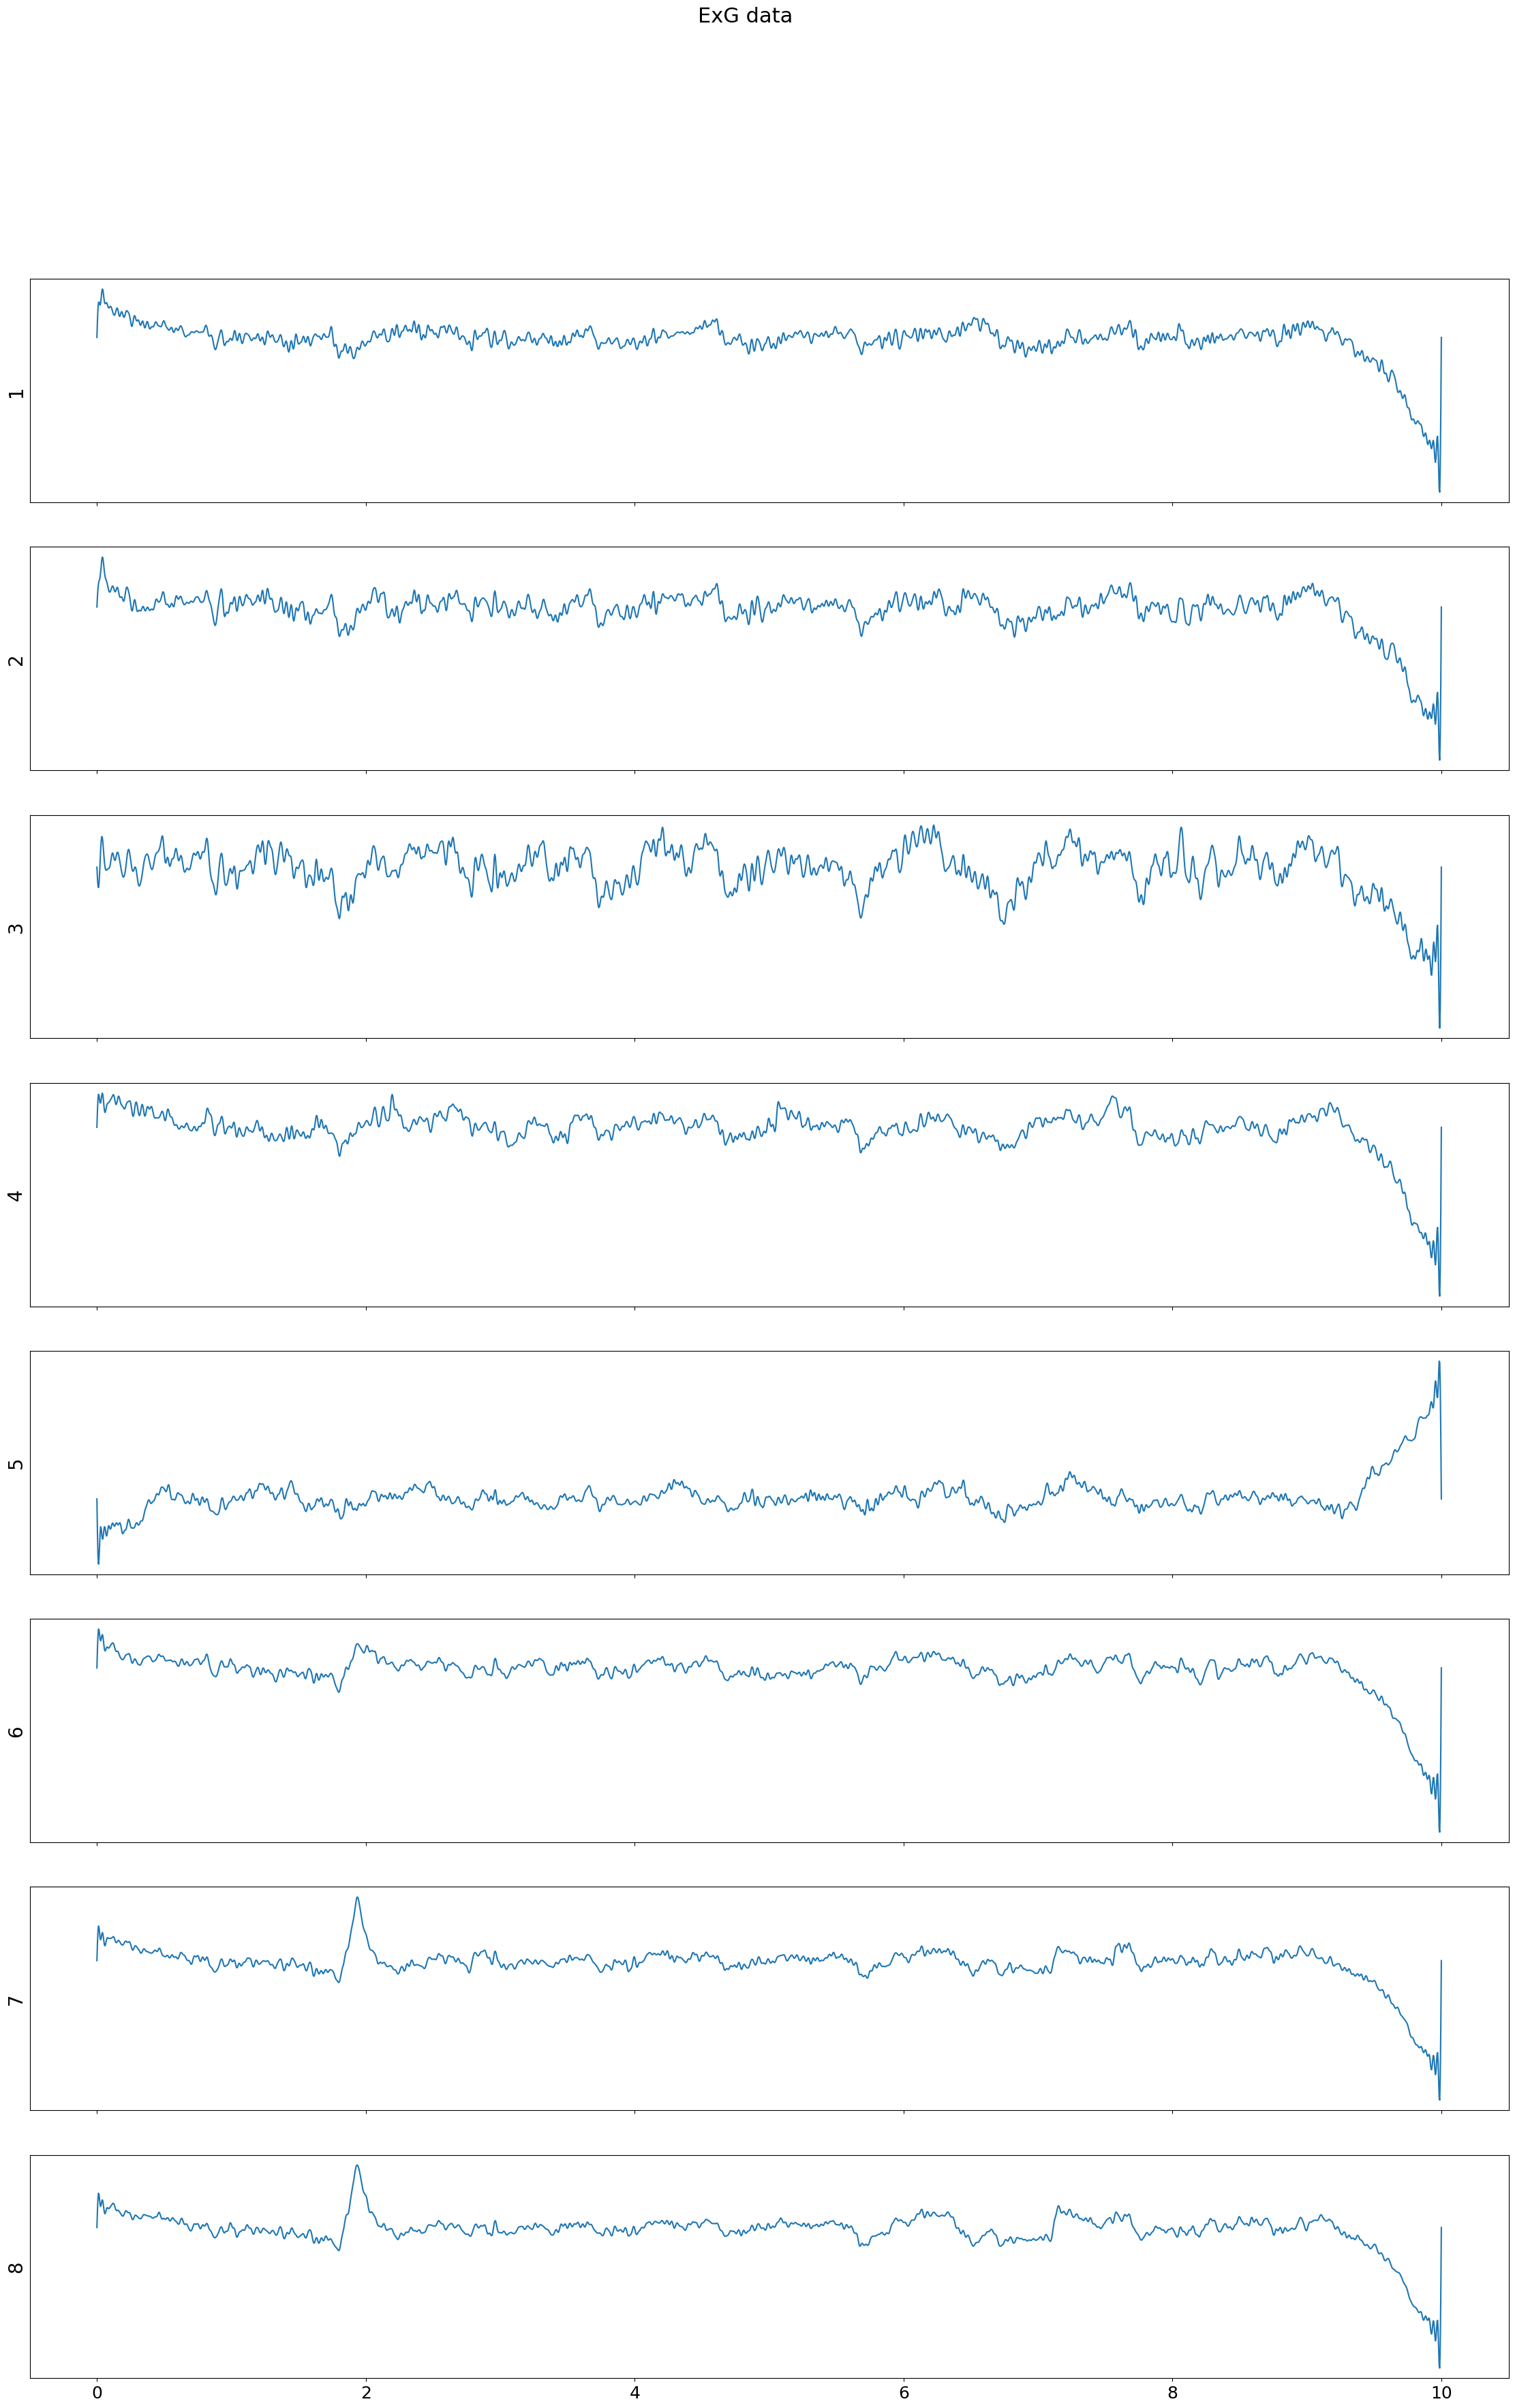

In [9]:
ExG_hpf = filtering.hp_filt(ExG_lpf, 1)
ExG_hpf.plot_ExGdata()
ExG_hpf.save_to_csv('out_ExG_hpf.csv')

## 4. Bad Channel Rejection (optional)

## 5. Wavelet Thresholding
1. Wavelet Transform  
    * Each electrode’s time series is subjected to wavelet transform.
    * Chosen wavelet function: Coiflet order 4 (`coif4`)
    * Level of Data Decomposition:
        * if sampling rate > 500 Hz = `10`
        * if 250 Hz < sampling rate <= 500 Hz = `9`
        * if sampling rate <= 250 Hz = `8`
2. Determining threshold values for each level
    * Wavelet coefficients are then subjected to thresholding (in a `level-dependent` way)
    * The chosen method to determine these threshold values: `Bayes`   
    (I. M. Johnstone, B. W. Silverman (2005). [Empirical Bayes Selection of Wavelet Thresholds](https://arxiv.org/pdf/math/0508281.pdf)) 
3. Thresholding
    * Thresholding rule: `Hard`
4. Reconstruction
    * The resulting coefficients are reconstructed into a signal

In [ ]:
from wav_thresholding import wav_thresholding

ExG_wav_thd = wav_thresholding(ExG_hpf)
ExG_wav_thd.plot_ExGdata()
ExG_wav_thd.save_to_csv('out_ExG_wav_thd.csv')

## 6. Segmentation (Optional)

## 7. Re-referencing (Optional)